# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


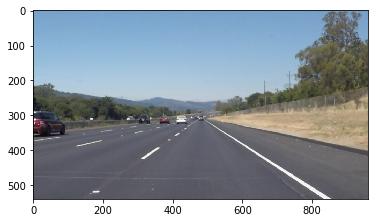

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, y_min,y_max, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_top_x_sum = 0
    left_bot_x_sum = 0
    right_top_x_sum = 0
    right_bot_x_sum = 0
    num_left_line = 0
    num_right_line = 0

    threshold = 0.5
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            if x1 != x2:
                m = get_line_slop(x1,y1,x2,y2)
                b = get_line_offset(x1,y1,x2,y2)
                
                if abs(m) > threshold:
                    x_top = get_x_from_y(y_min,m,b)
                    x_bot = get_x_from_y(y_max,m,b)
                    m = 100
                else:
                    x_top = 0
                    x_bot = 0
                    m = 0
            else:
                m = 100
                x_top = x1
                x_bot = x2
            
            if (x_top == x_top) and (x_bot == x_bot) and (m == 100):        
                if x_bot <= img.shape[0]:
                    #join left lane
                    left_top_x_sum += x_top
                    left_bot_x_sum += x_bot             
                    num_left_line += 1
                else:
                    #join right lane
                    right_top_x_sum += x_top
                    right_bot_x_sum += x_bot
                    num_right_line +=1
                    
    
    
    print(num_left_line,num_right_line)
    
    
    
    if num_left_line != 0:
        avg_x_left_top = int(left_top_x_sum // num_left_line)
        avg_x_left_bot = int(left_bot_x_sum // num_left_line)
        
    if num_right_line !=0:
        avg_x_right_top = int(right_top_x_sum // num_right_line)
        avg_x_right_bot = int(right_bot_x_sum // num_right_line)


    if num_left_line != 0 and num_right_line != 0:
        if avg_x_left_top > avg_x_right_top:
            # left and right line crossed path
            print(avg_x_left_top,y_min,avg_x_left_bot,y_max,avg_x_right_top,y_min,avg_x_right_bot,y_max)
            top_x,top_y = find_intersection(avg_x_left_top,y_min,avg_x_left_bot,y_max,avg_x_right_top,y_min,avg_x_right_bot,y_max)
            print(top_x,top_y)
            cv2.line(img, (int(top_x),int(top_y)), (avg_x_left_bot, y_max), color, thickness)
            cv2.line(img, (int(top_x),int(top_y)), (avg_x_right_bot, y_max), color, thickness)
            print("two lanes crossed path")
        else:
            cv2.line(img, (avg_x_left_bot, y_max), (avg_x_left_top, y_min), color, thickness)
            cv2.line(img, (avg_x_right_top, y_min), (avg_x_right_bot, y_max), color, thickness)


            
            
            
def find_intersection(x11,y11,x12,y12,x21,y21,x22,y22):
    # y1 = m1 * x1 + b1  -- (1)
    # y2 = m2 * x2 + b2  -- (2)
    # x1 = x2
    # y1 = y2
    # (1) - (2):
    # 0 = (m1 - m2) * x + b1 - b2
    # x = (b2-b1)/(m2-m1)
    # y = m1 * x + b1
    m1 = get_line_slop(x11,y11,x12,y12)
    m2 = get_line_slop(x21,y21,x22,y22)
    b1 = get_line_offset(x11,y11,x12,y12)
    b2 = get_line_offset(x21,y21,x22,y22)
    
    x = (b2-b1)/(m1-m2)
    y = m1 * x + b1
    return x, y
        
    
    
def get_line_slop(x1,y1,x2,y2):
    slope = (y1-y2)/(x1-x2)
    return slope
    
def get_line_offset(x1,y1,x2,y2):
    # y = mx + b
    # b = y - mx
    slope = get_line_slop(x1,y1,x2,y2)
    offset = y1 - slope * x1
    return offset
    
def get_x_from_y(y,m,b):
    # x = (y - b)/m
    x = (y - b)//m
    return x
    
    
    
    
    
    
    
    
    
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    
    if lines is not None:
        draw_lines(line_img, lines, 320,img.shape[0])
    else:
        print('did not find line')
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [17]:
import os
os.listdir("test_images/")

['crossPath.JPG',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

color selected image


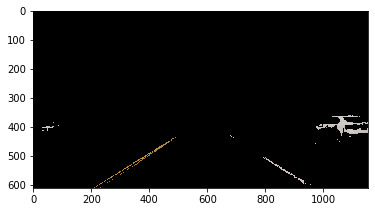

Canny edge image


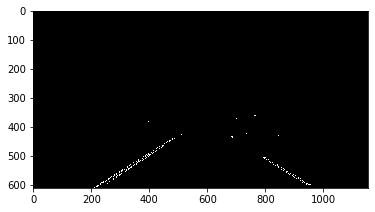

22 10
671 320 216 611 481 320 967 611
579.1296493092456 378.7566418703506
two lanes crossed path
final image


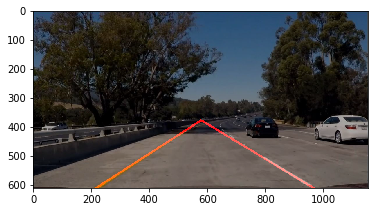

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def process_test_image(image):
    #select image to work on (start with test image 'image') 
    ysize = image.shape[0]
    xsize = image.shape[1]

    #color selection
    color_selected_img = np.copy(image)
    
    white_upper = (255,255,255)
    white_lower = (180,180,180)
    
    mask_white = cv2.inRange(image,white_lower, white_upper)
   
    yellow_upper = (255,255,80)
    yellow_lower = (160,120,40)
    
    mask_yellow = cv2.inRange(image,yellow_lower, yellow_upper)
        
    mask= cv2.bitwise_or(mask_white,mask_yellow)
    
    color_selected_img = cv2.bitwise_and(image,image,mask=mask)

    # Display the image                 
    print('color selected image')
    plt.imshow(color_selected_img)
    plt.show()

    #region of interest selection

    poly = np.array([[(100,ysize),(300,320),(xsize-300,320),(xsize-100,ysize)]])

    region_select_img = region_of_interest(color_selected_img, poly)
    
#    print('region selected image')
#    plt.imshow(region_select_img)
#    plt.show()

    #grayscaling
    gray = grayscale(region_select_img)
#    print('gray image')
#    plt.imshow(gray, cmap='gray')
#    plt.show()
    
    #Gaussian smoothing
    par_KernelSize = 3
    blur_gray = gaussian_blur(gray, par_KernelSize);
    
    #Canny Edge Detection

    v = np.median(blur_gray)
    #---- apply automatic Canny edge detection using the computed median----
    sigma = 0.33
    par_CannyLowThresh = int(max(0, (1.0 - sigma) * v))
    par_CannyHighThresh = int(min(255, (1.0 + sigma) * v))    
    
    #par_CannyLowThresh = 20
    #par_CannyHighThresh = 50
    edges = cv2.Canny(blur_gray, par_CannyLowThresh, par_CannyHighThresh)
    
    print('Canny edge image')
    plt.imshow(edges, cmap='Greys_r')
    plt.show()

    #Hough Tranform line detection
    par_HoughRho = 1
    par_HoughTheta = 5 * np.pi/180
    par_HoughThreshold = 30
    par_HoughMinLineLength = 15
    par_HoughMaxLineGap = 10

    line_image = hough_lines(edges, par_HoughRho,
                             par_HoughTheta,
                             par_HoughThreshold,
                             par_HoughMinLineLength,
                             par_HoughMaxLineGap)

#    print('Hough Line image')
#    plt.imshow(line_image)
#    plt.show()
    
    # overlay image
    final_img = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    print('final image')
    plt.imshow(final_img)
    plt.show()
    
    

for filename in os.listdir("test_images/"):
    image = mpimg.imread(os.path.join("test_images/", filename))
    process_test_image(image)
'''
image = mpimg.imread('test_images/crossPath.jpg')
process_image(image)
'''

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #select image to work on (start with test image 'image') 
    ysize = image.shape[0]
    xsize = image.shape[1]

    #color selection
    color_selected_img = np.copy(image)
    
    white_upper = (255,255,255)
    white_lower = (200,200,200)
    
    mask_white = cv2.inRange(image,white_lower, white_upper)
   
    yellow_upper = (255,255,80)
    yellow_lower = (160,120,40)
    
    mask_yellow = cv2.inRange(image,yellow_lower, yellow_upper)
        
    mask= cv2.bitwise_or(mask_white,mask_yellow)
    
    color_selected_img = cv2.bitwise_and(image,image,mask=mask)

    # Display the image                 
    #print('color selected image')
    #plt.imshow(color_selected_img)
    #plt.show()

    #region of interest selection

    poly = np.array([[(100,ysize),(300,320),(xsize-300,320),(xsize-100,ysize)]])

    region_select_img = region_of_interest(color_selected_img, poly)
    
#    print('region selected image')
#    plt.imshow(region_select_img)
#    plt.show()

    #grayscaling
    gray = grayscale(region_select_img)
#    print('gray image')
#    plt.imshow(gray, cmap='gray')
#    plt.show()
    
    #Gaussian smoothing
    par_KernelSize = 3
    blur_gray = gaussian_blur(gray, par_KernelSize);
    
    #Canny Edge Detection

    v = np.median(blur_gray)
    #---- apply automatic Canny edge detection using the computed median----
    sigma = 0.33
    par_CannyLowThresh = int(max(0, (1.0 - sigma) * v))
    par_CannyHighThresh = int(min(255, (1.0 + sigma) * v))    
    
    #par_CannyLowThresh = 20
    #par_CannyHighThresh = 50
    edges = cv2.Canny(blur_gray, par_CannyLowThresh, par_CannyHighThresh)
    
    #print('Canny edge image')
    #plt.imshow(edges, cmap='Greys_r')
    #plt.show()

    #Hough Tranform line detection
    par_HoughRho = 1
    par_HoughTheta = 5 * np.pi/180
    par_HoughThreshold = 30
    par_HoughMinLineLength = 15
    par_HoughMaxLineGap = 10

    line_image = hough_lines(edges, par_HoughRho,
                             par_HoughTheta,
                             par_HoughThreshold,
                             par_HoughMinLineLength,
                             par_HoughMaxLineGap)

#    print('Hough Line image')
#    plt.imshow(line_image)
#    plt.show()
    
    # overlay image
    result = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|█▏                                                                   | 4/221 [00:00<00:05, 37.50it/s, now=None]

7 18
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

7 18
8 18
8 20
4 22
2 18
2 19
2

t:   8%|█████▌                                                              | 18/221 [00:00<00:04, 47.87it/s, now=None]

 16
2 19
2 20
3 22
4 21
5 21
7 24
7 23
8 23
6 24
3 28
2 24
2 24
4 23


t:  15%|██████████▏                                                         | 33/221 [00:00<00:03, 57.17it/s, now=None]

3 22
2 20
3 24
5 23
7 22
10 24
8 26
7 25
3 23
2 27
3 21
2 27
2

t:  19%|████████████▌                                                       | 41/221 [00:00<00:02, 60.72it/s, now=None]

 26
4 21
2 22
4 20
7 20
6 19
8 23
6 25
3 21
2 23
2 20
2 21
2

t:  24%|████████████████▎                                                   | 53/221 [00:00<00:03, 51.41it/s, now=None]

 22
2 22
2 21
5 21
6 19
10 20
7 22
6 19
3 19
2 22


t:  30%|████████████████████▎                                               | 66/221 [00:01<00:02, 55.64it/s, now=None]

4 23
2 20
3 19
4 24
3 23
4 19
4 21
8 19
8 19
9 17
3 17
2 20
3

t:  33%|██████████████████████▏                                             | 72/221 [00:01<00:02, 53.29it/s, now=None]

 18
5 24
4 21
2 19
3 19
4 20
6 19
7 19
7 23
8

t:  38%|█████████████████████████▊                                          | 84/221 [00:01<00:02, 50.90it/s, now=None]

 15
4 17
1 14
2 15
2 16
3 14
3 13
5 14
5 12
6 10
8

t:  41%|███████████████████████████▋                                        | 90/221 [00:01<00:02, 52.11it/s, now=None]

 12
8 14
6 12
4 12
2 13
2 11
2 12
2 13
2 9
3 10


t:  46%|██████████████████████████████▉                                    | 102/221 [00:01<00:02, 51.29it/s, now=None]

4 11
6 9
7 11
11 9
7 9
3 10
2 10
2 11
3 11
2 14
2

t:  52%|██████████████████████████████████▊                                | 115/221 [00:02<00:01, 54.43it/s, now=None]

 10
4 10
5 14
6 10
9 13
8 11
6 11
4 12
2 11
2 12
2 12
2 17
2

t:  58%|███████████████████████████████████████                            | 129/221 [00:02<00:01, 60.18it/s, now=None]

 18
3 18
3 18
5 20
6 22
7 19
5 23
4 23
2 22
3 22
3 22
2 25
4

t:  62%|█████████████████████████████████████████▏                         | 136/221 [00:02<00:01, 59.97it/s, now=None]

 21
4 20
4 22
4 23
10 20
8 24
7 22
7 21
2 23
2 23
3

t:  67%|█████████████████████████████████████████████▏                     | 149/221 [00:02<00:01, 53.33it/s, now=None]

 22
3 19
2 24
3 19
3 22
7 23
8 21
10 25
5 19
4

t:  71%|███████████████████████████████████████████████▎                   | 156/221 [00:02<00:01, 55.55it/s, now=None]

 20
1 19
3 17
2 18
2 19
3 23
2 19
5 20
5 19
9 18
11 17
5 15
5 14


t:  76%|███████████████████████████████████████████████████▏               | 169/221 [00:03<00:00, 57.65it/s, now=None]

2 13
3 12
2 10
2 11
3 9
4 9
4 9
6 9
8 9
9 11
7 10
2

t:  83%|███████████████████████████████████████████████████████▍           | 183/221 [00:03<00:00, 60.15it/s, now=None]

 10
2 13
2 10
2 12
2 10
3 12
4 10
3 10
5 11
5 12
8 12
4 

t:  86%|█████████████████████████████████████████████████████████▌         | 190/221 [00:03<00:00, 58.16it/s, now=None]

11
5 10
2 12
2 9
2 9
3 9
3 8
2 7
4 5
4 6
6 8
7 8
6

t:  92%|█████████████████████████████████████████████████████████████▊     | 204/221 [00:03<00:00, 61.24it/s, now=None]

 9
3 9
1 7
1 8
2 5
3 7
2 8
4 9
2 7
5 9
8 8
11 7
9

t:  99%|██████████████████████████████████████████████████████████████████ | 218/221 [00:03<00:00, 64.53it/s, now=None]

 8
7 8
1 10
2 8
2 8
2 8
4 10
3 9
4 8
5 9
6 7
7 8
6 7
4

 7
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 4.14 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|▌                                                                    | 5/681 [00:00<00:13, 48.73it/s, now=None]

9 5
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

9 5
12 8
13 9
12 7
7 4
6 2
8 2
8 2
8 4
7 4


t:   3%|██                                                                  | 21/681 [00:00<00:11, 59.03it/s, now=None]

8 3
7 5
7 5
7 9
7 10
5 6
5 5
5 2
6 2
7 2
7 3
6 5
5 5
6 5
5 7


t:   5%|███▋                                                                | 37/681 [00:00<00:09, 65.59it/s, now=None]

6 5
8 9
7 7
7 6
7 4
8 2
13 3
9 3
12 3
9 4
9 3
10 5
12 6
11 8


t:   7%|█████                                                               | 51/681 [00:00<00:09, 64.12it/s, now=None]

14 8
11 6
11 6
11 2
10 3
11 3
11 4
10 4
10 5
11 5
10 5
11 5
11 10


t:  10%|██████▍                                                             | 65/681 [00:00<00:09, 64.36it/s, now=None]

12 9
8 9
9 4
11 2
11 2
10 3
10 2
9 2
9 5
8 5
8 6
9 7
8

t:  11%|███████▏                                                            | 72/681 [00:01<00:09, 63.67it/s, now=None]

 7
9 9
6 6
10 2
6 2
7 3
9 4
12 3
9 3
7 5
6 6
8 6
6

t:  13%|████████▌                                                           | 86/681 [00:01<00:09, 63.98it/s, now=None]

 9
9 10
10 5
10 4
8 2
9 2
9 3
10 2
5 3
8 5
6 5
6 7
7

t:  15%|█████████▉                                                         | 101/681 [00:01<00:08, 65.83it/s, now=None]

 8
5 10
9 8
6 6
6 3
7 1
7 1
5 3
7 4
7 4
8 3
7 4
7 5
7

t:  16%|██████████▋                                                        | 108/681 [00:01<00:09, 63.61it/s, now=None]

 7
6 11
6 12
10 6
8 6
9 1
7 3
9 2
7 3
6 4
8

t:  18%|████████████                                                       | 122/681 [00:01<00:09, 58.59it/s, now=None]

 5
10 5
8 6
10 8
8 9
6 8
7 6
10 3
7 3
10 3
7 3
9

t:  20%|█████████████▍                                                     | 137/681 [00:02<00:08, 62.97it/s, now=None]

 4
11 4
12 4
12 5
9 6
10 10
10 8
10 7
9 3
8 2
10 2
9 2
11 4
10 4


t:  21%|██████████████▏                                                    | 144/681 [00:02<00:08, 60.29it/s, now=None]

10 4
7 4
10 7
11 8
12 10
7 7
9 5
8 2
9 2
9 3
11 3
11

t:  23%|███████████████▋                                                   | 159/681 [00:02<00:08, 62.45it/s, now=None]

 4
12 4
11 5
12 5
10 6
10 8
11 11
10 6
9 5
7 2
9 2
10 3
8

t:  24%|████████████████▎                                                  | 166/681 [00:02<00:08, 62.85it/s, now=None]

 3
9 2
8 4
8 3
9 5
8 6
9 8
9 6
8 6
11 2
8 3
11 3
10

t:  27%|█████████████████▊                                                 | 181/681 [00:02<00:07, 65.72it/s, now=None]

 3
11 4
12 5
14 4
13 6
10 6
12 8
13 8
17 5
16 2
14 1
13 2
16 3
11 3
14

t:  29%|███████████████████▍                                               | 197/681 [00:03<00:06, 69.31it/s, now=None]

 3
14 4
12 4
13 5
12 7
13 7
14 5
12 3
14 3
12 2
12 2
11 4
15 4
13 3
14

t:  31%|████████████████████▊                                              | 212/681 [00:03<00:06, 69.70it/s, now=None]

 4
14 6
13 7
15 10
18 8
16 8
12 4
15 2
13 2
11 3
13 3
13 3
13 4


t:  33%|██████████████████████▎                                            | 227/681 [00:03<00:06, 70.52it/s, now=None]

12 3
11 7
13 7
12 7
11 9
10 6
10 2
10 2
12 3
13 3
14 2
14 4
8 5
12 4
14

t:  35%|███████████████████████                                            | 235/681 [00:03<00:06, 65.63it/s, now=None]

 9
12 7
11 8
14 8
11 2
8 3
12 3
9 3
10 3
9 4
10

t:  36%|███████████████████████▊                                           | 242/681 [00:03<00:07, 61.00it/s, now=None]

 4
10 8
10 8
12 11
13 9
11 8
9 5
9 2
8 2
10 2
6

t:  37%|█████████████████████████                                          | 255/681 [00:03<00:07, 56.16it/s, now=None]

 3
9 2
8 3
7 3
10 4
9 4
6 6
9 6
10 7
12 7
10

t:  39%|██████████████████████████▎                                        | 267/681 [00:04<00:07, 55.45it/s, now=None]

 3
8 1
11 3
11 3
9 3
10 4
8 5
13 3
8 4
9 7
8

t:  40%|██████████████████████████▊                                        | 273/681 [00:04<00:07, 55.52it/s, now=None]

 9
8 8
11 5
9 2
11 3
9 3
7 3
9 4
11 4
8 3
7 5
10

t:  42%|████████████████████████████                                       | 285/681 [00:04<00:07, 55.51it/s, now=None]

 7
9 9
8 8
9 6
8 6
12 3
11 3
8 3
8 3
9 2
6

t:  44%|█████████████████████████████▏                                     | 297/681 [00:04<00:07, 52.59it/s, now=None]

 5
7 4
481 320 169 540 479 320 859 540
480.0982658959537 320.6358381502891
two lanes crossed path
6 6
482 320 169 540 479 320 857 540
480.6410998552821 320.9551374819103
two lanes crossed path
2 7
485 320 170 540 474 320 857 540
480.0358166189112 323.4670487106018
two lanes crossed path
3 6
484 320 170 540 479 320 857 540
481.7312138728324 321.5895953757226
two lanes crossed path
3 8
481 320 168 540 479 320 857 540
480.09406657018815 320.6367583212736
two lanes crossed path
5 7
480 320 168 540 479 320 860 540
479.5497835497837 320.3174603174603
two lanes crossed path
5 2
7 2
7

t:  44%|█████████████████████████████▊                                     | 303/681 [00:04<00:07, 52.23it/s, now=None]

 2
5 2
7 3
6 4
480 320 169 540 478 320 861 540
479.10374639769447 320.6340057636888
two lanes crossed path
7 3
480 320 167 540 479 320 856 540
479.54637681159414 320.3188405797102
two lanes crossed path
7 6
481 320 167 540 479 320 857 540
480.09248554913296 320.63583815028903
two lanes crossed path
5 6
480 320 169 540 477 320 854 540
478.6438953488372 320.9593023255814
two lanes crossed path
6 10
6 6
478 320 167 540 477 320 854 540
477.54796511627916 320.31976744186045
two lanes crossed path
7 3
6

t:  46%|██████████████████████████████▉                                    | 315/681 [00:05<00:07, 51.99it/s, now=None]

 2
7 2
8 3
10 3
9 4
7 5
7 4
7 7
7 10
7 11


t:  47%|███████████████████████████████▌                                   | 321/681 [00:05<00:07, 50.77it/s, now=None]

6 7
6 6
7 4
7 2
11 2
10 2
9 3
7 4
9 3
6 5


t:  49%|████████████████████████████████▊                                  | 333/681 [00:05<00:06, 51.01it/s, now=None]

11 6
11 9
10 8
10 7
10 4
7 2
6 2
6 3
8 3
4 3
5

t:  51%|█████████████████████████████████▉                                 | 345/681 [00:05<00:06, 51.46it/s, now=None]

 4
5 4
5 5
6 9
4 6
2 5
4 3
4 2
6 3
6 2
3

t:  53%|███████████████████████████████████▎                               | 359/681 [00:05<00:05, 56.76it/s, now=None]

 2
5 4
5 5
4 3
4 7
5 9
5 9
4 6
4 3
6 1
4 3
6 2
5 3
5

t:  54%|████████████████████████████████████                               | 366/681 [00:06<00:05, 59.91it/s, now=None]

 3
8 4
6 4
6 7
5 11
6 11
7 10
8 6
8 2
8 2
9 3
8 3
8 3
8

t:  56%|█████████████████████████████████████▌                             | 382/681 [00:06<00:04, 65.59it/s, now=None]

 6
7 4
10 7
10 10
10 11
8 9
10 4
8 2
9 3
8 2
7 3
8 4
8 3
8 5
5

t:  57%|██████████████████████████████████████▎                            | 390/681 [00:06<00:04, 66.45it/s, now=None]

 5
6 8
6 10
9 7
6 5
6 2
4 2
5 3
5 4
3

t:  59%|███████████████████████████████████████▋                           | 404/681 [00:06<00:04, 57.24it/s, now=None]

 4
7 3
4 5
6 5
9 6
6 9
8 10
11 6
7 2
9 3
9 2
9

t:  60%|████████████████████████████████████████▍                          | 411/681 [00:06<00:04, 58.04it/s, now=None]

 2
7 2
8 3
10 4
8 4
7 4
6 9
5 10
6 6
8 

t:  62%|█████████████████████████████████████████▌                         | 423/681 [00:07<00:04, 53.12it/s, now=None]

4
7 2
9 2
7 2
7 2
7 4
6 4
7 5
6 4
8 11
6 10
7

t:  64%|██████████████████████████████████████████▉                        | 437/681 [00:07<00:04, 57.81it/s, now=None]

 8
8 4
6 2
7 2
6 3
5 2
6 3
7 4
3 4
5 6
6 9
7

t:  65%|███████████████████████████████████████████▊                       | 445/681 [00:07<00:03, 61.22it/s, now=None]

 9
4 9
5 7
6 1
5 2
3 2
4 3
5 2
7 4
7 4
7 5
8 5
6

t:  67%|█████████████████████████████████████████████                      | 458/681 [00:07<00:03, 56.06it/s, now=None]

 6
10 8
5 10
6 6
6 2
5 3
6 2
8 2
9 3
8 4
8

t:  69%|██████████████████████████████████████████████▏                    | 470/681 [00:07<00:03, 53.74it/s, now=None]

 3
8 6
9 9
6 13
8 8
7 7
9 4
7 2
6 2
8 3
7

t:  70%|██████████████████████████████████████████████▊                    | 476/681 [00:07<00:03, 53.44it/s, now=None]

 3
10 4
7 4
9 4
6 7
6 10
7 8
5 6
6 4
7 2
5

t:  72%|████████████████████████████████████████████████                   | 488/681 [00:08<00:03, 53.27it/s, now=None]

 2
9 2
6 2
5 3
5 5
5 6
5 7
6 10
6 11
7 8
7

t:  73%|█████████████████████████████████████████████████▏                 | 500/681 [00:08<00:03, 53.07it/s, now=None]

 5
7 1
8 2
6 3
9 2
7 2
6 5
5 4
10 6
6 7


t:  74%|█████████████████████████████████████████████████▊                 | 506/681 [00:08<00:03, 50.96it/s, now=None]

7 11
9 9
9 6
8 2
9 1
8 2
8 2
9 4
6 3

t:  75%|██████████████████████████████████████████████████▎                | 512/681 [00:08<00:03, 49.95it/s, now=None]


7 4
8 4
6 7
7 9
9 10
10 7
13 4
7 2
9 2


t:  77%|███████████████████████████████████████████████████▌               | 524/681 [00:08<00:03, 50.41it/s, now=None]

9 2
10 2
9 4
11 3
8 6
15 6
9 6
10 9
13 5
11 5
13 2
12

t:  79%|████████████████████████████████████████████████████▉              | 538/681 [00:09<00:02, 58.47it/s, now=None]

 2
11 2
9 3
9 4
10 3
9 4
6 5
8 7
7 9
6 8
6 5
5 2
6 2
9

t:  81%|██████████████████████████████████████████████████████▍            | 553/681 [00:09<00:02, 62.79it/s, now=None]

 3
6 2
8 4
5 4
5 6
7 4
9 9
6 10
6 7
8 6
9 3
7 2
6 2


t:  83%|███████████████████████████████████████████████████████▉           | 568/681 [00:09<00:01, 65.49it/s, now=None]

7 2
9 3
8 3
8 3
5 3
4 6
7 8
7 12
9 6
6 6
6 1
6 2
8 2
9

t:  84%|████████████████████████████████████████████████████████▌          | 575/681 [00:09<00:01, 66.45it/s, now=None]

 4
7 3
8 3
8 5
8 5
8 6
9 8
9 7
8 6
10 2
8 1
8 3
11 3
8 2


t:  87%|██████████████████████████████████████████████████████████         | 590/681 [00:09<00:01, 67.55it/s, now=None]

10 4
7 5
8 6
6 5
8 10
7 7
10 6
10 5
9 4
8 4
7 5
10 4
8 3
9

t:  89%|███████████████████████████████████████████████████████████▌       | 606/681 [00:10<00:01, 69.46it/s, now=None]

 2
8 4
8 5
7 6
5 9
9 8
7 6
7 2
7 2
8 2
7 4
8 3
9 3
7

t:  90%|████████████████████████████████████████████████████████████▎      | 613/681 [00:10<00:00, 69.26it/s, now=None]

 3
7 6
8 8
9 7
6 7
7 8
6 2
6 2
6 4
8 3
6 3
6

t:  92%|█████████████████████████████████████████████████████████████▋     | 627/681 [00:10<00:00, 58.02it/s, now=None]

 3
4 2
5 3
8 4
4 7
5 5
5 6
4 4
5 1
5 2
8

t:  94%|███████████████████████████████████████████████████████████████    | 641/681 [00:10<00:00, 60.57it/s, now=None]

 2
4 3
5 2
3 5
4 4
5 6
5 5
5 6
4 5
4 4
4 2
6 3
7

t:  95%|███████████████████████████████████████████████████████████████▊   | 648/681 [00:10<00:00, 60.86it/s, now=None]

 2
6 3
6 4
7 5
6 4
6 6
7 4
7 7
7 8
4 7
7 4
7 2


t:  97%|█████████████████████████████████████████████████████████████████▏ | 662/681 [00:11<00:00, 59.63it/s, now=None]

8 2
8 2
10 2
9 3
9 3
10 4
13 3
7 5
11 6
13 9
9 6
8

t:  99%|██████████████████████████████████████████████████████████████████▌| 677/681 [00:11<00:00, 65.61it/s, now=None]

 4
9 2
7 3
8 3
8 5
9 3
9 4
7 5
10 5
10 8
9 10
12 8
7 5
11 1
12

 2
10 4
11 3
11 4
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 11.6 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|█                                                                    | 4/251 [00:00<00:06, 36.39it/s, now=None]

25 7
786 320 221 720 470 320 1159 720
643.6236044657097 420.79744816586924
two lanes crossed path
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

25 7
786 320 221 720 470 320 1159 720
643.6236044657097 420.79744816586924
two lanes crossed path
28 7
797 320 209 720 481 320 1151 720
649.2988871224167 420.47694753577093
two lanes crossed path
28 4
795 320 214 720 480 320 1153 720
649.055023923445 420.4784688995215
two lanes crossed path
25 2
792 320 218 720 504 320 1140 720
655.3785123966943 415.20661157024784
two lanes crossed path
26 2
798 320 213 720 500 320 1144 720
656.1529698942229 416.98942229454843
two lanes crossed path
23 3
793 320 221 720 496 320 1149 720
654.3191836734694 416.97959183673464


t:   6%|███▊                                                                | 14/251 [00:00<00:06, 39.01it/s, now=None]

two lanes crossed path
27 4
795 320 222 720 508 320 1138 720
658.2992518703242 415.4280964256027
two lanes crossed path
29 4
797 320 224 720 506 320 1141 720
658.9677152317881 416.35761589403967
two lanes crossed path
28 5
797 320 227 720 502 320 1148 720
658.71875 417.0394736842105
two lanes crossed path
25 8
825 320 268 720 506 320 1141 720
675.9370805369127 427.0469798657719
two lanes crossed path
27 10
792 320 233 720 492 320 1150 720
654.2021364009859 418.60312243221045
two lanes crossed path
25 10
801 320 230 720 476 320 1156 720
652.6586730615508 423.91686650679463
two lanes crossed path
23 11
798 320 232 720 520 320 1160 720
667.5290215588723 412.2056384742952
two lanes crossed path
24

t:   8%|█████▏                                                              | 19/251 [00:00<00:05, 39.70it/s, now=None]

 9
798 320 231 720 475 320 1164 720
652.187101910828 422.86624203821657
two lanes crossed path
23 5
802 320 230 720 474 320 1172 720
654.2708661417322 423.30708661417333
two lanes crossed path
28 3
799 320 231 720 495 320 1155 720
658.3876221498372 419.0228013029316
two lanes crossed path
27 2
799 320 230 720 502 320 1144 720
659.4516928158547 418.10074318744836
two lanes crossed path
21 4
793 320 233 720 503 320 1139 720
657.2140468227425 416.98996655518397
two lanes crossed path
23 4
804 320 228 720 502 320 1141 720
660.8296296296296 419.4238683127572
two lanes crossed path
28 4
813 320 237 720 499 320 1140 720
664.3853738701724 423.20460147904686
two lanes crossed path
25 3
793 320 233 720 490 320 1144 720
653.2306425041187 419.83525535420097
two lanes crossed path
26 4
805 320 247 720 470 320 1164 720
655.6948881789137 427.0287539936102


t:  12%|███████▊                                                            | 29/251 [00:00<00:05, 40.87it/s, now=None]

two lanes crossed path
26 6
796 320 229 720 470 320 1155 720
648.3626198083067 424.1533546325879
two lanes crossed path
23 11
795 320 231 720 474 320 1151 720
649.1144238517323 423.46494762288484
two lanes crossed path
22 7
800 320 225 720 463 320 1159 720
647.5413060582218 426.0582218725413
two lanes crossed path
24 6
793 320 230 720 463 320 1158 720
645.3131955484897 424.92845786963426
two lanes crossed path
30 4
790 320 229 720 486 320 1147 720
650.4386252045826 419.5090016366612
two lanes crossed path
27 2
792 320 228 720 522 320 1113 720
660.1558441558442 413.5064935064934
two lanes crossed path
26 4
804 320 247 720 528 320 1107 720
668.6725352112676 417.18309859154937
two lanes crossed path
26

t:  13%|████████▉                                                           | 33/251 [00:00<00:05, 39.32it/s, now=None]

 2
790 320 225 720 502 320 1136 720
654.2869057547957 416.0800667222685
two lanes crossed path
25 5
796 320 226 720 600 320 1138 720
695.1696750902528 390.75812274368224
two lanes crossed path
23 4
793 320 224 720 512 320 1120 720
657.1554800339848 415.4970263381478
two lanes crossed path
21 7
796 320 219 720 513 320 1122 720
658.3178752107926 415.44688026981447
two lanes crossed path
24 6
794 320 218 720 499 320 1136 720
653.9175597691674 417.27947238252267
two lanes crossed path
25 8
805 320 208 720 474 320 1146 720
649.2813238770686 424.3341213553978
two lanes crossed path
25 9
785 320 221 720 464 320 1149 720
640.048839071257 422.8022417934347
two lanes crossed path


t:  16%|███████████                                                         | 41/251 [00:01<00:05, 38.64it/s, now=None]

26 9
794 320 213 720 467 320 1144 720
642.9769475357712 423.97456279809217
two lanes crossed path
23 8
792 320 215 720 472 320 1150 720
644.8764940239043 421.9920318725099
two lanes crossed path
27 3
794 320 217 720 645 320 1167 720
715.7716105550501 374.23111919927203
two lanes crossed path
27 4
793 320 220 720 624 320 1141 720
704.1587155963304 382.01834862385317
two lanes crossed path
26 3
793 320 217 720 664 320 1146 720
722.7693761814745 368.7712665406427
two lanes crossed path
25 4
792 320 217 720 623 320 1145 720
703.4175022789425 381.6226071103008
two lanes crossed path
24 5
801 320 209 720 576 320 1164 720
688.1186440677966 396.27118644067804
two lanes crossed path
25 3
800 320 215 720 471 320 1162 720
649.1653605015674 423.13479623824446
two lanes crossed path


t:  20%|█████████████▎                                                      | 49/251 [00:01<00:05, 37.74it/s, now=None]

24 5
793 320 222 720 572 320 1164 720
684.4952708512468 396.01031814273426
two lanes crossed path
26 6
796 320 220 720 556 320 1160 720
678.8474576271186 401.3559322033898
two lanes crossed path
28 8
800 320 222 720 536 320 1161 720
673.1571072319201 407.780548628429
two lanes crossed path
29 10
803 320 224 720 517 320 1160 720
667.4893617021277 413.6170212765958
two lanes crossed path
29 9
792 320 230 720 528 320 1161 720
667.8426778242679 408.36820083682005
two lanes crossed path
24 7
801 320 224 720 541 320 1161 720
675.6700083542189 406.88387635756055
two lanes crossed path
21 3
795 320 231 720 660 320 1150 720
722.7609108159392 371.23339658444036
two lanes crossed path
19

t:  23%|███████████████▍                                                    | 57/251 [00:01<00:05, 35.78it/s, now=None]

 2
800 320 228 720 755 320 1144 720
773.2154006243496 338.7304890738815
two lanes crossed path
25 3
799 320 230 720 655 320 1154 720
722.2808988764044 373.932584269663
two lanes crossed path
23 5
801 320 229 720 598 320 1145 720
697.2323503127792 392.56478999106355
two lanes crossed path
23 4
796 320 228 720 626 320 1139 720
706.6753006475486 382.90471785383903
two lanes crossed path
27 6
798 320 231 720 593 320 1130 720
692.7146739130434 394.2753623188406
two lanes crossed path
23 5
801 320 225 720 492 320 1143 720
655.9437652811737 420.7334963325183
two lanes crossed path
24 6
799 320 232 720 498 320 1135 720
657.25 420.00000000000006
two lanes crossed path

t:  26%|█████████████████▌                                                  | 65/251 [00:01<00:05, 35.08it/s, now=None]


25 10
798 320 230 720 471 320 1152 720
649.2922337870295 424.7237790232186
two lanes crossed path
20 9
800 320 225 720 466 320 1151 720
647.5793650793651 426.031746031746
two lanes crossed path
26 10
800 320 227 720 471 320 1150 720
649.4273162939296 425.11182108626207
two lanes crossed path
23 5
796 320 226 720 485 320 1157 720
653.2705314009661 420.16103059581326
two lanes crossed path
26 2
798 320 225 720 529 320 1113 720
664.7787381158167 412.99913569576495
two lanes crossed path
20 2
801 320 218 720 510 320 1142 720
661.3679012345679 415.8024691358025
two lanes crossed path
28

t:  27%|██████████████████▋                                                 | 69/251 [00:01<00:05, 34.57it/s, now=None]

 2
798 320 221 720 504 320 1146 720
658.8383921246924 416.4725184577523
two lanes crossed path
26 3
800 320 224 720 517 320 1130 720
662.9032800672834 415.20605550883096
two lanes crossed path
25 4
796 320 222 720 524 320 1126 720
663.2380952380953 412.517006802721
two lanes crossed path
24 3
811 320 211 720 495 320 1151 720
660.0445859872611 420.6369426751592
two lanes crossed path
21 4
807 320 219 720 480 320 1169 720
656.4314800313235 422.42756460454183
two lanes crossed path
26 4
803 320 234 720 477 320 1169 720
655.8992862807295 423.409992069786
two lanes crossed path
19 9
804 320 235 720 475 320 1172 720
656.1319115323854 423.9494470774093
two lanes crossed path


t:  31%|████████████████████▊                                               | 77/251 [00:02<00:05, 34.57it/s, now=None]

28 11
806 320 237 720 479 320 1174 720
658.7982594936709 423.4810126582279
two lanes crossed path
19 10
812 320 238 720 477 320 1177 720
661.065934065934 425.18053375196234
two lanes crossed path
25 6
799 320 241 720 525 320 1224 720
677.3675417661098 407.1917263325378
two lanes crossed path
26 2
808 320 243 720 474 320 1192 720
660.9150428682775 424.1309431021044
two lanes crossed path
23 3
807 320 240 720 481 320 1183 720
661.340425531915 422.7580772261623
two lanes crossed path
30 3
803 320 246 720 480 320 1181 720
659.9864864864866 422.70270270270265
two lanes crossed path
25 2
808 320 244 720 479 320 1184 720
661.7777777777778 423.7037037037037
two lanes crossed path
26

t:  34%|███████████████████████                                             | 85/251 [00:02<00:04, 35.50it/s, now=None]

 3
798 320 252 720 481 320 1185 720
659.5343999999999 421.44
two lanes crossed path
29 5
808 320 246 720 484 320 1185 720
663.8289786223279 422.6128266033254
two lanes crossed path
35 8
791 320 255 720 487 320 1185 720
658.9546191247974 418.5413290113452
two lanes crossed path
31 12
785 320 256 720 505 320 1193 720
663.2908792111751 412.0295809367296
two lanes crossed path
31 17
810 320 250 720 490 320 1186 720
667.3248407643312 421.9108280254777
two lanes crossed path
23 12
802 320 253 720 526 320 1179 720
675.9400998336106 411.846921797005
two lanes crossed path
25 9
785 320 259 720 494 320 1177 720
658.3945409429281 416.2779156327543
two lanes crossed path
28 2
802 320

t:  37%|█████████████████████████▏                                          | 93/251 [00:02<00:04, 36.75it/s, now=None]

 251 720 477 320 1187 720
659.9896907216496 423.0927835051545
two lanes crossed path
29 4
794 320 257 720 575 320 1090 720
682.2100760456274 403.26996197718637
two lanes crossed path
20 2
797 320 259 720 485 320 1174 720
660.19804400978 421.71149144254275
two lanes crossed path
23 5
760 320 279 720 487 320 1172 720
647.3816466552316 413.6535162950256
two lanes crossed path
26 3
804 320 260 720 481 320 1179 720
662.5249597423511 424.0257648953301
two lanes crossed path
18 3
760 320 282 720 480 320 1175 720
645.8994032395567 415.4816709292412
two lanes crossed path
21 3
760 320 278 720 481 320 1176 720
645.7451146983857 414.8173322005098
two lanes crossed path
30 5
787 320 274 720 485 320 1179 720
658.6437448218725 420.0828500414249


t:  39%|██████████████████████████▎                                         | 97/251 [00:02<00:04, 36.86it/s, now=None]

two lanes crossed path
22 10
765 320 282 720 485 320 1184 720
650.5837563451777 414.7546531302877
two lanes crossed path
23 12
761 320 283 720 486 320 1189 720
649.6960203217611 413.1414055884844
two lanes crossed path
22 9
760 320 282 720 488 320 1188 720
649.6298811544991 412.3599320882852
two lanes crossed path
23 4
755 320 281 720 489 320 1188 720
647.5115089514068 410.70758738277914
two lanes crossed path
23 1
760 320 280 720 457 320 1212 720
642.2348178137652 418.1376518218624
two lanes crossed path
30 0
25

t:  43%|████████████████████████████▌                                      | 107/251 [00:02<00:03, 38.50it/s, now=None]

 0
22 0
32 0
22 3
771 320 258 720 473 320 1178 720
645.487684729064 417.86535303776685
two lanes crossed path
22 2
762 320 263 720 475 320 1174 720
642.456594323873 415.82637729549253
two lanes crossed path
26 2
789 320 250 720 470 320 1173 720
650.561191626409 422.7375201288245
two lanes crossed path
22 2
784 320 255 720 470 320 1173 720
649.1737012987013 421.94805194805195
two lanes crossed path
20 8
754 320 262 720 469 320 1178 720
637.2472939217319 414.92089925062453
two lanes crossed path


t:  44%|█████████████████████████████▋                                     | 111/251 [00:02<00:04, 34.54it/s, now=None]

17 7
744 320 262 720 460 320 1170 720
629.1610738255034 415.30201342281873
two lanes crossed path
15 7
746 320 252 720 468 320 1175 720
631.6519567027476 412.5895087427145
two lanes crossed path
15 9
762 320 240 720 491 320 1165 720
643.7207357859533 410.63545150501665
two lanes crossed path
12 1
737 320 237 720 477 320 1185 720
629.384105960265 406.092715231788
two lanes crossed path
13 1
758 320 221 720 485 320 1178 720
638.8121951219513 408.780487804878
two lanes crossed path
18

t:  46%|██████████████████████████████▋                                    | 115/251 [00:03<00:04, 32.93it/s, now=None]

 2
779 320 210 720 491 320 1169 720
647.5870088211707 412.3817161186849
two lanes crossed path
18 2
770 320 202 720 483 320 1188 720
641.9434406912806 410.18067556952076
two lanes crossed path
19 2
769 320 202 720 484 320 1186 720
641.6595744680851 409.8345153664303
two lanes crossed path
21 3
785 320 212 720 474 320 1178 720
645.4518402505872 417.4158183241974
two lanes crossed path
21 2
775 320 214 720 476 320 1177 720
642.0847860538828 414.770206022187
two lanes crossed path
21 4
789 320 211 720 475 320 1164 720
645.7545382794002 419.13180741910026
two lanes crossed path


t:  49%|████████████████████████████████▊                                  | 123/251 [00:03<00:04, 29.25it/s, now=None]

21 7
781 320 212 720 471 320 1164 720
641.229793977813 418.256735340729
two lanes crossed path
18 6
781 320 203 720 469 320 1165 720
639.4489795918367 417.9591836734694
two lanes crossed path
22 5
779 320 205 720 470 320 1157 720
638.3449643140365 418.0174464710547
two lanes crossed path
23 10
781 320 194 720 473 320 1162 720
639.3103448275862 416.55172413793105
two lanes crossed path
23 9
770 320 192 720 474 320 1149 720
633.4573024740622 414.4932162809258
two lanes crossed path
18

t:  51%|█████████████████████████████████▉                                 | 127/251 [00:03<00:04, 28.33it/s, now=None]

 5
781 320 188 720 480 320 1146 720
639.2263701350279 415.6314535345512
two lanes crossed path
28 2
787 320 186 720 531 320 1105 720
656.0587234042554 407.14893617021266
two lanes crossed path
26 2
778 320 191 720 527 320 1104 720
651.421821305842 406.254295532646
two lanes crossed path
24 3
778 320 191 720 522 320 1109 720
650.0 407.2231686541737
two lanes crossed path
22 2
778 320 185 720 500 320 1133 720
643.5350734094616 410.7014681892333
two lanes crossed path
22

t:  53%|███████████████████████████████████▌                               | 133/251 [00:03<00:04, 26.44it/s, now=None]

 4
773 320 189 720 503 320 1129 720
642.6859504132232 409.25619834710744
two lanes crossed path
22 4
772 320 191 720 499 320 1137 720
641.8826907301067 409.5816242821985
two lanes crossed path
23 3
778 320 189 720 508 320 1124 720
646.0248962655602 409.6265560165975
two lanes crossed path
27 8
777 320 188 720 509 320 1128 720
646.3278145695364 408.74172185430467
two lanes crossed path
22 12
801 320 171 720 479 320 1145 720
644.4722222222222 419.38271604938274
two lanes crossed path
26

t:  56%|█████████████████████████████████████▎                             | 140/251 [00:04<00:03, 28.60it/s, now=None]

 10
802 320 167 720 473 320 1145 720
642.1568477429228 420.68859984697775
two lanes crossed path
23 8
786 320 170 720 464 320 1154 720
634.1225114854518 418.6217457886677
two lanes crossed path
26 3
793 320 173 720 511 320 1116 720
650.2734693877552 412.0816326530612
two lanes crossed path
26 2
811 320 163 720 503 320 1126 720
653.9708890637294 416.93154996066096
two lanes crossed path
21 2
794 320 176 720 492 320 1134 720
645.8761904761905 415.87301587301585
two lanes crossed path
23 2
812 320 169 720 494 320 1130 720
652.1297888975763 419.4526974198593
two lanes crossed path
28

t:  57%|██████████████████████████████████████▍                            | 144/251 [00:04<00:03, 30.03it/s, now=None]

 4
810 320 166 720 499 320 1127 720
652.5440251572327 417.7987421383648
two lanes crossed path
24 4
815 320 165 720 495 320 1128 720
652.879968823071 419.7661730319563
two lanes crossed path
24 5
800 320 170 720 498 320 1123 720
648.398406374502 416.25498007968133
two lanes crossed path
28 6
801 320 162 720 506 320 1122 720
650.796812749004 414.02390438247016
two lanes crossed path
25 8
801 320 172 720 466 320 1140 720
639.2847275518035 422.8396009209516
two lanes crossed path
23 10
792 320 178 720 465 320 1145 720
636.839258114374 421.0819165378671
two lanes crossed path
23 7
837 320 165 720 455 320 1137 720
647.4106351550961 432.85081240768096
two lanes crossed path
24 4
812 320 170 720 496 320 1133 720
653.3823299452697 418.82720875684134


t:  61%|████████████████████████████████████████▌                          | 152/251 [00:04<00:03, 30.92it/s, now=None]

two lanes crossed path
25 0
22 0
11 0
14 0
16 2
828 320 167 720 481 320 1129 720
652.7769289533996 426.035141329259
two lanes crossed path
13

t:  62%|█████████████████████████████████████████▋                         | 156/251 [00:04<00:02, 31.86it/s, now=None]

 3
834 320 159 720 485 320 1131 720
655.66919000757 425.67751703255107
two lanes crossed path
10 6
841 320 154 720 486 320 1126 720
657.2132629992465 427.008289374529
two lanes crossed path
9 8
839 320 158 720 470 320 1135 720
652.3068350668648 429.6582466567608
two lanes crossed path
4 3
850 320 148 720 501 320 1113 720
663.5479452054794 426.24048706240484
two lanes crossed path
6 0
7 1
829 320 143 720 531 320 1108 720
667.1409342834521 414.37846397466353
two lanes crossed path
8 1
833 320 132 720 530 320 1110 720
667.1896955503513 414.6135831381733
two lanes crossed path


t:  65%|███████████████████████████████████████████▊                       | 164/251 [00:04<00:02, 32.81it/s, now=None]

13 3
834 320 133 720 533 320 1105 720
668.2490180675569 414.5797329143754
two lanes crossed path
22 2
834 320 141 720 530 320 1102 720
667.4608695652174 416.1264822134387
two lanes crossed path
13 4
836 320 139 720 527 320 1107 720
667.3445575567738 416.7893500391542
two lanes crossed path
16 3
836 320 136 720 533 320 1111 720
670.0375586854459 414.83568075117375
two lanes crossed path
25 6
840 320 145 720 502 320 1127 720
662.0378787878788 422.42424242424244
two lanes crossed path
19 7
846 320 154 720 510 320 1119 720
667.282090699462 423.3051498847041
two lanes crossed path
24

t:  69%|█████████████████████████████████████████████▉                     | 172/251 [00:05<00:02, 33.65it/s, now=None]

 12
848 320 156 720 491 320 1131 720
662.5315315315315 427.2072072072072
two lanes crossed path
30 14
853 320 161 720 495 320 1124 720
665.4632853898563 428.40272520817564
two lanes crossed path
22 10
855 320 165 720 487 320 1128 720
664.2261457550713 430.5935386927123
two lanes crossed path
19 4
860 320 174 720 467 320 1121 720
658.8074626865672 437.3134328358209
two lanes crossed path
28 2
857 320 182 720 523 320 1092 720
675.7700964630226 427.39549839228295
two lanes crossed path
27 3
853 320 191 720 511 320 1097 720
671.5865384615385 429.61538461538464
two lanes crossed path
31 3
830 320 207 720 484 320 1132 720
660.402832415421 428.89063729346964
two lanes crossed path
27

t:  70%|██████████████████████████████████████████████▉                    | 176/251 [00:05<00:02, 32.60it/s, now=None]

 3
812 320 207 720 499 320 1123 720
657.9194467046381 421.8714401952806
two lanes crossed path
27 5
800 320 216 720 505 320 1124 720
656.7913549459686 418.08811305070645
two lanes crossed path
26 5
799 320 209 720 507 320 1132 720
657.2057613168723 416.13168724279836
two lanes crossed path
29 3
793 320 210 720 491 320 1144 720
650.5517799352751 417.7346278317152
two lanes crossed path
25 6
789 320 218 720 471 320 1155 720
644.3163346613546 421.3545816733067
two lanes crossed path
24 11
790 320 218 720 469 320 1157 720
644.2761904761905 421.90476190476187
two lanes crossed path
24

t:  73%|█████████████████████████████████████████████████                  | 184/251 [00:05<00:02, 32.85it/s, now=None]

 12
799 320 217 720 472 320 1153 720
648.3159144893112 423.562945368171
two lanes crossed path
26 7
794 320 222 720 477 320 1148 720
648.1238938053096 422.01126307321
two lanes crossed path
25 4
799 320 213 720 489 320 1151 720
653.4391025641025 419.3589743589744
two lanes crossed path
24 2
793 320 223 720 503 320 1141 720
656.1622516556291 416.0264900662252
two lanes crossed path
25 3
790 320 224 720 510 320 1132 720
656.5993265993267 414.27609427609417
two lanes crossed path
28 2
809 320 210 720 478 320 1168 720
655.1838634600466 422.71528316524433
two lanes crossed path
22

t:  75%|██████████████████████████████████████████████████▏                | 188/251 [00:05<00:02, 30.19it/s, now=None]

 2
797 320 226 720 477 320 1166 720
651.984126984127 421.5873015873016
two lanes crossed path
24 3
786 320 229 720 478 320 1169 720
648.5352564102564 418.7179487179488
two lanes crossed path
22 3
804 320 231 720 472 320 1158 720
652.8991262907069 425.48054011119933
two lanes crossed path
21 5
806 320 235 720 486 320 1147 720
657.6883116883117 423.8961038961039
two lanes crossed path
25 8
804 320 236 720 469 320 1166 720
653.5810276679842 425.92885375494063
two lanes crossed path


t:  78%|████████████████████████████████████████████████████               | 195/251 [00:05<00:02, 27.20it/s, now=None]

27 9
812 320 237 720 474 320 1166 720
658.6061562746646 426.7087608524072
two lanes crossed path
22 13
807 320 241 720 476 320 1171 720
658.4306106264868 424.9960348929422
two lanes crossed path
25 7
801 320 239 720 475 320 1169 720
655.1305732484077 423.82165605095537
two lanes crossed path
31 2
801 320 242 720 512 320 1145 720
665.4706375838925 416.9798657718121
two lanes crossed path
27 3
802 320 240 720 505 320 1161 720
664.9605911330049 417.53694581280797
two lanes crossed path
29

t:  79%|████████████████████████████████████████████████████▊              | 198/251 [00:05<00:01, 26.95it/s, now=None]

 2
806 320 240 720 512 320 1149 720
667.6758104738155 417.75561097256855
two lanes crossed path
27 2
792 320 242 720 512 320 1154 720
662.8053691275169 413.95973154362406
two lanes crossed path
28 3
805 320 240 720 482 320 1177 720
660.1626984126984 422.53968253968253
two lanes crossed path
24 3
784 320 247 720 487 320 1176 720
653.9110929853181 416.9004893964111
two lanes crossed path
25 5
807 320 239 720 484 320 1179 720
661.7395091053048 422.29612034837686
two lanes crossed path
24

t:  81%|██████████████████████████████████████████████████████▍            | 204/251 [00:06<00:01, 26.93it/s, now=None]

 7
802 320 243 720 480 320 1175 720
658.4609250398724 422.7113237639553
two lanes crossed path
24 8
803 320 242 720 480 320 1178 720
659.0738681493248 422.6211278792693
two lanes crossed path
27 10
796 320 243 720 485 320 1177 720
657.8610441767069 419.9196787148594
two lanes crossed path
28 9
786 320 247 720 481 320 1178 720
652.9943365695792 418.705501618123
two lanes crossed path
36 7
784 320 248 720 481 320 1176 720
652.068237205524 418.4565393988627
two lanes crossed path
26 2
786 320 251 720 505 320 1147 720
658.2727272727271 415.49702633814786
two lanes crossed path


t:  84%|████████████████████████████████████████████████████████▎          | 211/251 [00:06<00:01, 28.61it/s, now=None]

26 2
786 320 249 720 506 320 1143 720
657.9250425894379 415.4003407155025
two lanes crossed path
29 3
790 320 250 720 511 320 1135 720
660.5670103092783 415.8762886597938
two lanes crossed path
27 4
791 320 250 720 487 320 1156 720
655.0793388429752 420.4958677685951
two lanes crossed path
23 3
785 320 255 720 496 320 1152 720
655.8516020236087 417.47048903878584
two lanes crossed path
25 3
801 320 249 720 476 320 1168 720
656.7877813504822 424.50160771704185
two lanes crossed path
29 5
800 320 249 720 478 320 1173 720
657.6067415730337 423.37078651685397
two lanes crossed path
27

t:  86%|█████████████████████████████████████████████████████████▍         | 215/251 [00:06<00:01, 30.04it/s, now=None]

 8
794 320 251 720 483 320 1180 720
657.8120967741936 420.3225806451613
two lanes crossed path
30 11
787 320 258 720 479 320 1185 720
655.0712550607287 419.7570850202429
two lanes crossed path
32 9
790 320 256 720 482 320 1183 720
656.8242914979757 419.7570850202429
two lanes crossed path
30 8
793 320 260 720 479 320 1189 720
658.3563958165728 421.0458567980692
two lanes crossed path
31 2
775 320 270 720 486 320 1180 720
653.2777314428689 416.41367806505434
two lanes crossed path
37 3
767 320 275 720 486 320 1187 720
651.113998323554 414.21626152556576
two lanes crossed path
29 2
779 320 268 720 483 320 1185 720
654.3042044517725 417.6092333058532
two lanes crossed path


t:  89%|███████████████████████████████████████████████████████████▌       | 223/251 [00:06<00:00, 31.87it/s, now=None]

28 3
761 320 273 720 482 320 1191 720
647.2556390977443 413.23308270676694
two lanes crossed path
23 3
761 320 273 720 483 320 1189 720
647.3785594639866 413.13232830820766
two lanes crossed path
25 4
757 320 279 720 483 320 1180 720
645.5344680851064 413.2765957446809
two lanes crossed path
24 5
767 320 267 720 477 320 1187 720
647.1652892561983 415.8677685950413
two lanes crossed path
26 7
764 320 273 720 481 320 1185 720
647.7213389121339 414.7280334728033
two lanes crossed path
28 11
766 320 267 720 477 320 1185 720
646.5211267605634 415.7746478873239
two lanes crossed path
27

t:  92%|█████████████████████████████████████████████████████████████▋     | 231/251 [00:06<00:00, 33.47it/s, now=None]

 15
778 320 259 720 486 320 1183 720
653.3717105263157 416.0526315789474
two lanes crossed path
23 10
771 320 267 720 475 320 1178 720
647.4009942004972 418.09444904722454
two lanes crossed path
23 3
769 320 266 720 469 320 1170 720
643.6677740863787 419.66777408637876
two lanes crossed path
24 2
775 320 264 720 469 320 1177 720
646.7260049220672 420.4101722723544
two lanes crossed path
31 2
770 320 264 720 505 320 1133 720
651.7548500881834 413.4744268077601
two lanes crossed path
31 2
760 320 266 720 477 320 1168 720
642.023628691983 415.52742616033765
two lanes crossed path
33 4
775 320 260 720 475 320 1171 720
647.4194880264243 419.0916597853015
two lanes crossed path
30

t:  94%|██████████████████████████████████████████████████████████████▋    | 235/251 [00:07<00:00, 34.14it/s, now=None]

 4
794 320 247 720 486 320 1164 720
656.4685714285713 420.5714285714286
two lanes crossed path
31 3
784 320 251 720 481 320 1176 720
652.4861563517916 418.6970684039087
two lanes crossed path
28 5
779 320 260 720 480 320 1170 720
650.6451612903226 418.9247311827957
two lanes crossed path
30 8
783 320 252 720 479 320 1176 720
651.5472312703583 419.0228013029316
two lanes crossed path
30 12
783 320 252 720 480 320 1177 720
651.979641693811 418.6970684039089
two lanes crossed path
29 9
762 320 264 720 478 320 1171 720
643.249370277078 415.3820319059614
two lanes crossed path
30 5
794 320 244 720 484 320 1174 720
656.4999999999999 420.0000000000001
two lanes crossed path


t:  97%|████████████████████████████████████████████████████████████████▊  | 243/251 [00:07<00:00, 34.11it/s, now=None]

25 2
763 320 260 720 505 320 1149 720
649.8578901482128 409.9738448125544
two lanes crossed path
28 3
784 320 250 720 481 320 1179 720
652.6672077922078 418.37662337662334
two lanes crossed path
30 3
792 320 250 720 519 320 1130 720
663.6686903729401 414.70945359930613
two lanes crossed path
29 4
788 320 255 720 489 320 1159 720
655.5253532834581 419.4181213632585
two lanes crossed path
28 4
786 320 248 720 492 320 1159 720
654.736929460581 417.59336099585056
two lanes crossed path
26 3
791 320 246 720 475 320 1167 720
651.7760711398545 422.1827000808408
two lanes crossed path
30

t:  98%|█████████████████████████████████████████████████████████████████▉ | 247/251 [00:07<00:00, 32.50it/s, now=None]

 3
791 320 243 720 473 320 1166 720
650.5777598710717 422.497985495568
two lanes crossed path
25 8
786 320 245 720 475 320 1172 720
650.0945072697899 420.4846526655897
two lanes crossed path
32 10
786 320 246 720 481 320 1162 720
651.1105651105652 419.91809991809987
two lanes crossed path
28 9
792 320 243 720 474 320 1169 720
651.66077170418 422.25080385852095
two lanes crossed path
27 7
790 320 244 720 473 320 1168 720
650.5302175664785 422.17566478646256
two lanes crossed path
22 2
788 320 244 720 473 320 1177 720
650.6923076923076 420.96153846153857
two lanes crossed path


29 2
805 320 240 720 481 320 1171 720
659.1354581673306 423.26693227091636
two lanes crossed path
Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 8.12 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))